## Задание 5 по курсу «Компьютерное зрение»
**Выполнил:** студент Б05-911 Кудрявцев Иван

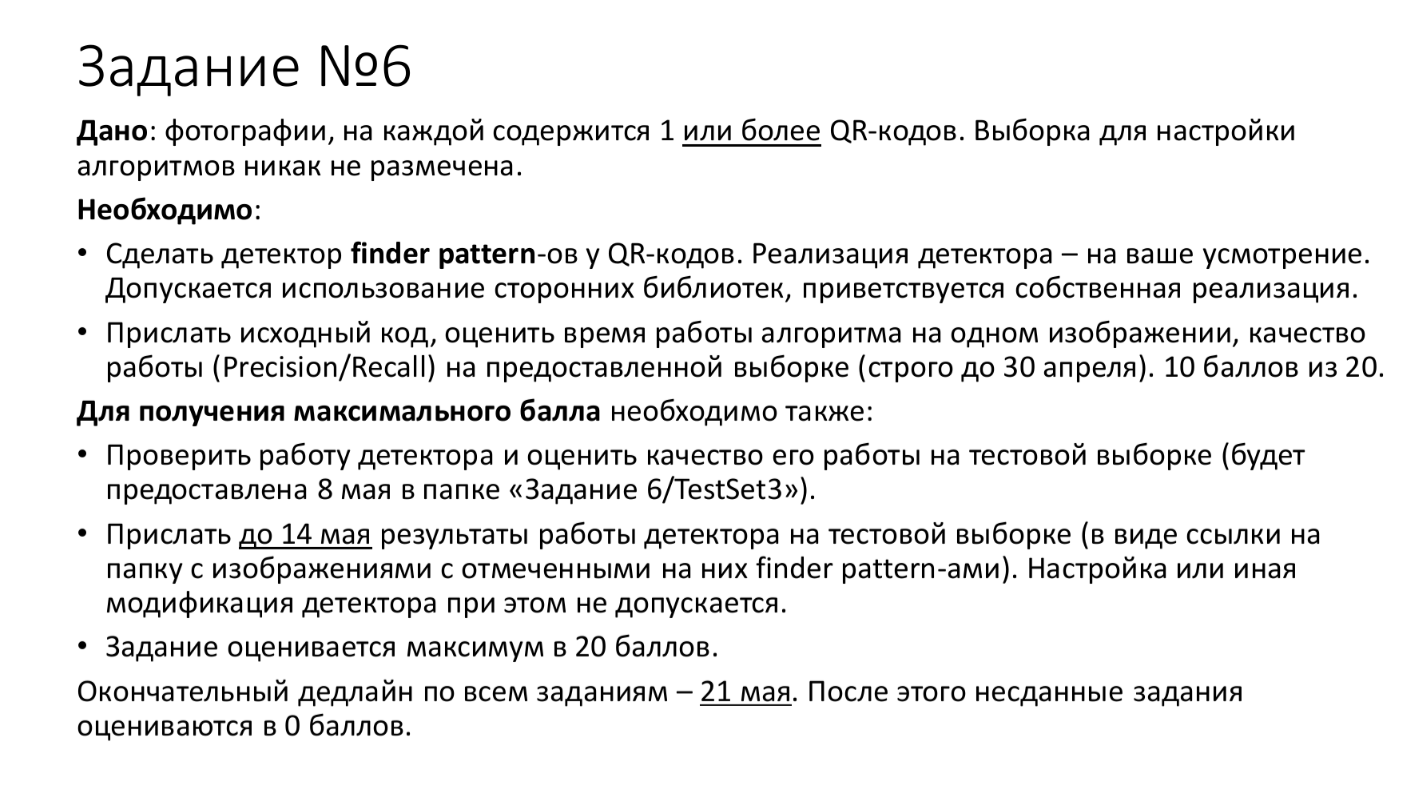

In [8]:
from PIL import Image
import numpy as np
import cv2
import time


def show(image_bgr_array):
    return Image.fromarray(np.array(cv2.cvtColor(image_bgr_array, cv2.COLOR_BGR2RGB), dtype=np.uint8))

In [9]:
def preprocess_image(img):
    # Гауссово размытие изображения для уменьшения влияния шумов
    kernel_size = (11, 11)
    img = cv2.GaussianBlur(img, ksize=kernel_size, sigmaX=0, sigmaY=0)
    
    # Адаптивная бинаризация 
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)

    # После адаптивной бинаризации возникает много белых 
    # точек среди черного и черных точек среди белого.
    # Поэтому необходимо сделать морфологическое закрытие
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    
    # Чтобы края черной линии лучше обнаруживались в дальнейшем, 
    # нужно увеличить их толщину с помощью эрозии (белое уменьшается, черное увеличивается)
    img = cv2.erode(img, np.ones((3, 3), np.uint8), iterations=1)

    return img

def areas_compare(areas, etalone, err=0.5):
    # Будем сравнивать i со всеми следующими, 
    # а потом i+1 со всеми следующими, и так далее
    etalone_12 = etalone[0] / etalone[1]
    etalone_13 = etalone[0] / etalone[2]
    etalone_23 = etalone[1] / etalone[2]
    
    for i in range(len(areas) - 2):
        for j in range(i+1, len(areas) - 1):
            for k in range(j+1, len(areas)):
                ratio_12 = areas[i] / areas[j]
                ratio_13 = areas[i] / areas[k]
                ratio_23 = areas[j] / areas[k]

            b1 = np.isclose(ratio_12, etalone_12, etalone_12 * err)
            b2 = np.isclose(ratio_13, etalone_13, etalone_13 * err)
            b3 = np.isclose(ratio_23, etalone_23, etalone_23 * err)
            if  b1 and b2 and b3:
                return True

    return False


def find_qr(img):
    # Поиск краев алгоритмом Canny -- в нашем случае полезно искать 
    # края между белым и черным для детекции вложенных квадратов в 3 углах qr-кода
    # Статья: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.420.3300&amp;rep=rep1&amp;type=pdf
    # Туториал: https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html
    edges = cv2.Canny(img, 70, 70*3, 7)
    
    # Используем классический метод opencv для поиска контуров, 
    # сохранив иерархию
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    hierarchy = hierarchy[0]
    
    finded_contours = []
    parrents_used = []
    for parrent_contour in range(hierarchy.shape[0]):
        current_contour = parrent_contour
        hierarchy_level = 0
        areas = []
        contours_in_finder_pattern = []

        # Смотрим на вложенные контуры и изучаем их иерархию
        while hierarchy[current_contour][2] != -1:
            contours_in_finder_pattern += [current_contour]
            
            areas += [cv2.contourArea(contours[current_contour])]
            hierarchy_level += 1
            current_contour = hierarchy[current_contour][2]
            
        # Последний по вложенности контур
        if hierarchy[current_contour][2] != -1:
            areas += [cv2.contourArea(contours[current_contour])]
            hierarchy_level += 1

        # Если нашлось от 3 до 6 вложенных контуров, то это, вероятно,
        # искомый finder pattern одной из 3х меток QR-кода.
        # Чтобы удостовериться наверняка проверим коэфициенты подобия этих квадратов
        # Чтобы нивелировать влияние искажени, будем использовать площади контуров
        # и сравнивать их соотношения. Правильное для QR-кода: 7^2 / 5^2 / 3^2 = 49/25/9
        if 4 <= hierarchy_level <= 8:
            etalone = (49.0, 25.0, 9.0)
            if (parrent_contour not in parrents_used) and areas_compare(areas, etalone):
                contour = contours[parrent_contour]
                epsilon = 0.05 * cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, epsilon, True)

                # Проверка на то, что контур является прямоугольником
                if len(approx) == 4 and cv2.isContourConvex(approx):
                    finded_contours += [approx]
                    parrents_used += contours_in_finder_pattern

    return finded_contours
    
def process_image(img):
    start = time.time()

    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grey_img_preprocessed = preprocess_image(grey_img)

    finded_patterns = find_qr(grey_img_preprocessed)

    end = time.time()

    for contour in finded_patterns:
        cv2.drawContours(img, [contour], 0, (255, 255, 0), 5, cv2.LINE_8)

    return img, end - start

In [10]:
import glob
import cv2
import os


def get_filenames(path, regexp='*', extensions=None, recursive=True):
    if recursive:
        path += '**/'
    path += regexp

    files_grabbed = []
    for extension in extensions:
        files_grabbed.extend(glob.glob(path + '.' + extension, recursive=recursive))

    return files_grabbed

def load_image(file_path):
    return cv2.imread(file_path)

def save_image(file_path, image):
    cv2.imwrite(filename=file_path, img=image)

In [11]:
from tqdm import tqdm


def process_images(input_dir, output_dir):
    time = 0

    filenames = get_filenames(input_dir, extensions=['jpg'], recursive=False)

    for img_filename in tqdm(filenames):
        # print(img_filename)
        img, time_i = process_image(load_image(img_filename))
        time += time_i
        save_image(os.path.join(output_dir, os.path.basename(img_filename)), img)
        
    if len(filenames) == 0:
        return None
    
    mean_time = time / len(filenames)
    return mean_time

In [12]:
# TEST
input_path = '/Users/vankudr/Yandex.Disk.localized/MIPT/7 term/Abbyy/CV/task 6/'
output_path = '/Users/vankudr/Yandex.Disk.localized/MIPT/7 term/Abbyy/CV/task 6/Output/'

mean_time = process_images(input_path, output_path)
print(mean_time)

0it [00:00, ?it/s]

None


In [13]:
input_path = '/Users/vankudr/Yandex.Disk.localized/MIPT/7 term/Abbyy/CV/task 6/TestSet1/'
output_path = '/Users/vankudr/Yandex.Disk.localized/MIPT/7 term/Abbyy/CV/task 6/TestSet1Output/'

mean_time = process_images(input_path, output_path)

100%|██████████| 47/47 [00:29<00:00,  1.60it/s]


In [14]:
print(mean_time)

0.21039480351387185


In [15]:
input_path = '/Users/vankudr/Yandex.Disk.localized/MIPT/7 term/Abbyy/CV/task 6/TestSet2/'
output_path = '/Users/vankudr/Yandex.Disk.localized/MIPT/7 term/Abbyy/CV/task 6/TestSet2Output/'

mean_time = process_images(input_path, output_path)

100%|██████████| 48/48 [00:32<00:00,  1.49it/s]


In [16]:
print(mean_time)

0.24868781864643097


In [17]:
input_path = '/Users/vankudr/Yandex.Disk.localized/MIPT/7 term/Abbyy/CV/task 6/TestSet3/'
output_path = '/Users/vankudr/Yandex.Disk.localized/MIPT/7 term/Abbyy/CV/task 6/TestSet3Output/'

mean_time = process_images(input_path, output_path)

100%|██████████| 150/150 [01:31<00:00,  1.63it/s]


In [18]:
print(mean_time)

0.17273192723592123


Среднее время обработки одного изображения получилось:
- Для TestSet1: 0.22 с (предыдущий, первый запуск ноутбука)
- Для TestSet2: 0.37 с (предыдущий, первый запуск ноутбука)
- Для TestSet3: 0.17 с (последний запуск после появления TestSet3)

Метрики Precison и Recall я считал по правильному / неправильному считыванию квадратов в углах qr-кодов (на каждом qr-коде должно быть, в идеале, считано 3 квадрата)

**Test1**
- TP = 106
- FP = 0
- FN = 38
- Precision = 1.00
- Recall = 0.74

**Test2**
- TP = 109
- FP = 1
- FN = 56
- Precision = 0.99
- Recall = 0.66

**Test3**
- TP = 207
- FP = 53
- FN = 175
- Precision = 0.80
- Recall = 0.54